### 2 - Sentiment Analysis of the First 3 Weeks 


Love Island has [often been criticized](https://www.cosmopolitan.com/uk/entertainment/a26846803/mike-thalassitiss-death-reaction-love-island-twitter/) for not looking after the mental health of contestants; with two previous contestants having committed suicide there have been for [calls to pull the show](https://www.thesun.co.uk/tvandshowbiz/8705713/love-island-mike-thalassitis-sophie-gradon-suicide-reality-tv/), the fact that the Jeremy Kyle show was canceled due to [the death of a participant](https://www.wired.co.uk/article/jeremy-kyle-show-mental-illness) a few weeks leading up to Love Island being aired added a lot of fuel to the fire. In response, prior to announcing this season, the producers of the show and ITV placed a [large emphasis](https://www.itv.com/presscentre/press-releases/itv-outlines-duty-care-processes-ahead-series-5-itv2s-love-island) focusing on the "aftercare" of cast members, with this change being one of the [largest to this series](https://www.gq-magazine.co.uk/article/love-island-mental-health); whilst there has been a lot of [cynicism about this online](https://graziadaily.co.uk/life/tv-and-film/love-island-aftersun-ovie/), this has generally been received well by the public. According to both ex-islanders and mental health professionals, one of the main sources of pressure for islanders when they leave the villa is [social media and constantly hearing negative messages from the public about themselves](https://www.radiotimes.com/news/tv/2019-05-15/reality-tv-mental-health-love-island-big-brother/). 

In this notebook I aim to investigate the sentiment behind tweets that reference love island, specifically tweets that explicitly mention the individual contestants to determine both the scale of the problem and to observe if we can see reactions to events during the show playing out in the twitter data. 

Before finding the sentiment of each tweet the raw text need to be cleaned, the literature however is very inconsistent with how "heavy-handed" one should be when putting together a pipeline for cleaning text, especially twitter data. On the one hand, [authors suggest](https://pdfs.semanticscholar.org/6969/5bc9dcb5da81e305af8bf85ab5ca4d6619a9.pdf) that leaving tweets alone is the correct way to do it, with nuances in language and placement of capital letters etc being some of the features of raw text that should be being picked up by the analysis. [Other authors](http://ceur-ws.org/Vol-1748/paper-06.pdf) suggest that reducing the tweets down to only keep the fundamental parts, for example, removing stop words, normalizing case and generally trying to only feed the algorithms the really crucial parts of the text is the correct approach. For this piece my preprocessing will have a number of rules, this is mainly to try and reduce noise in the data and given we have such a large corpus and the "none typical" nature of the topics that are to be discussed, one would expect the standard text cleaning algorithms to produce good results, the steps I am going to follow are:
- Normalize case (making all text lower case)
- Remove punctuation 
- Strip all leading and trailing whitespace 
- Remove numbers 
- Remove non-ASCII characters (this is just precautionary as twitter shouldn't allow ASCII characters)
- Remove all references to "love island" ("love" is a very heavily weighted word in terms of sentiment analysis and for a tweet to be included in our data we know that it will include the "#loveisland", therefore it is imperative that this is removed) 
- Remove stop words (words such as "and", "then" etc; they don't add anything in terms of sentiment to the tweet)
- Lemmatise each word (this makes the word usage in the whole corpus more consistent, lemmatising effectively shortens words to their root, so "making" would be transformed to "make", "kissed" to "kiss" etc)
- Remove words that are shorter than 3 characters (at this point given the heavy natured approach of the above steps words with 2 or fewer characters will just be errors or not important) 
The bulk of this preprocessing is done is via base python and the excellent [spaCy](https://spacy.io/) package. 

In terms of the full "end to end pipeline" of going from raw text data to presenting analysis, I am going to "borrow" the pipeline steps set out in [Wang et al's paper that analyses tweets on the US presidential election](https://www.aclweb.org/anthology/P12-3020), however mine will be in a slightly different order. Firstly I will match islanders to each tweet, pre-process the text as per the above steps, find the sentiment of each tweet and then aggregate and visualize. To find the sentiment of each tweet I am going to use the compound score produced by running each tweet through the `SentimentIntensityAnalyzer` class from the [NLTK](https://www.nltk.org/) package, no initial validation has been done to check that this method is applicable to this corpus but we shall validate as we go along. 

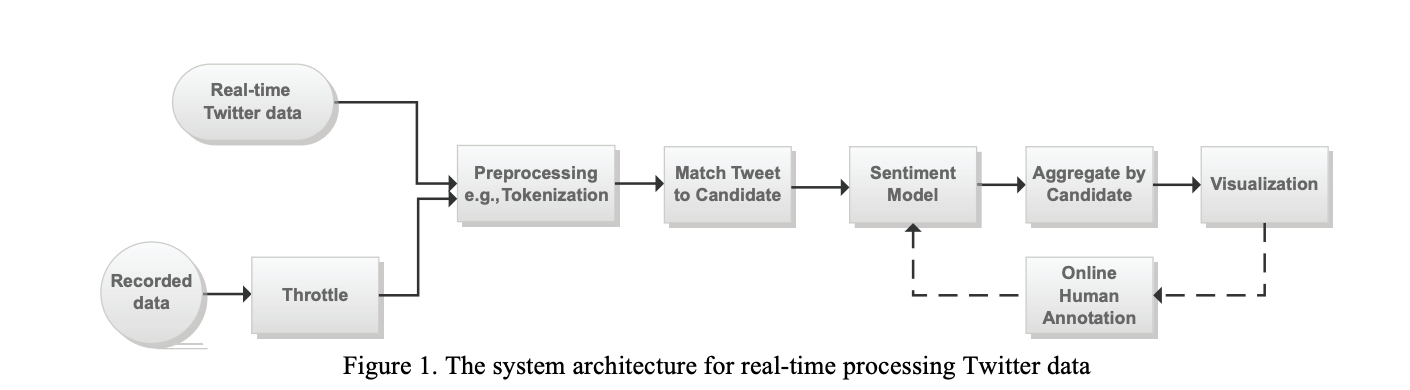

https://www.aclweb.org/anthology/P12-3020


In [30]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt 

from loveisland.common.constants import ISLANDERS
from loveisland.common.functions import Functions as F

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [31]:
ISLANDERS = {k: v for k, v in ISLANDERS.items() if v["season"] == 5}

PALETTE = F.get_palette()
ORIGINAL_ISLANDERS = F.get_islanders()

islander_df = F.get_islander_df()
RELEVANT_ISLANDERS = islander_df[
    (islander_df["arrived"] <= 21) & (islander_df["season"] == 5)
]["islander"]


In [32]:
class SentimentFuncts:
    @staticmethod
    def dt_filters(df, first="2019-06-03", last="2019-06-23"):
        return df[(first <= df["date"]) & (df["date"] <= last)]

    @staticmethod
    def inc_islander(df, col="islanders"):
        df[col] = df[col].apply(lambda x: F.str_to_list(x))
        df["inc_islander"] = df[col].apply(lambda x: len(x))
        df["inc_islander"] = np.where(df["inc_islander"] < 1, "No", "Yes")
        return df

    @staticmethod
    def islander_agg(df, islander):
        """Aggregate various metrics per islander/date"""
        AGG_JS = {
            "favs": "mean",
            "retwe": "mean",
            "score": "mean",
            "user": "nunique",
            "url": "count",
            "weight_senti": "mean",
        }
        RN_JS = {islander: "islander", "url": "n_tweets", "user": "n_users"}
        df = df[df[islander] == islander]
        df = df[df["score"] != 0]
        if len(df) > 0:
            return (
                df.groupby([islander, "date"])
                .agg(AGG_JS)
                .reset_index()
                .rename(columns=RN_JS)
            )
        return pd.DataFrame()

    def aggregate_all(self, df):
        """Loop over all islanders, aggregating metrics"""
        agg_df = pd.DataFrame()
        for islander in RELEVANT_ISLANDERS:
            agg = self.islander_agg(df, islander)
            agg_df = agg_df.append(agg, sort=True)
        return agg_df.reset_index(drop=True)

    @staticmethod
    def add_cols(df, islander_df):
        df["total_favs"] = df["favs"] * df["n_tweets"]
        df["total_retwe"] = df["retwe"] * df["n_tweets"]
        df = df.merge(islander_df, on="islander", how="left")
        df["n_days"] = np.where(df["dumped"] != 0, df["dumped"] - df["arrived"], 21)
        return df

    @staticmethod
    def format_xticks(df, ax, n=1, col="date", rotate=True):
        x_dates = df["date"].dt.strftime("%Y-%m-%d").sort_values().unique()
        ax.xaxis.set_major_formatter(plt.FixedFormatter(x_dates))

        if rotate:
            plt.xticks(rotation=20, ha="right")

        xticks = ax.xaxis.get_major_ticks()
        for i in range(len(xticks)):
            if i % n != 0:
                xticks[i].set_visible(False)

    @staticmethod
    def add_meta(ax, y, title, legend=True, x="Date"):
        if legend:
            ax.legend(bbox_to_anchor=(1, -0.2), ncol=11)
        ax.set_title(title)
        ax.set_xlabel(x)
        ax.set_ylabel(y)

    @staticmethod
    def add_colours(ax, storyline):
        for key, item in storyline.items():
            ax.axvline(
                item["date"], color=item["color"], linewidth=item["t"], alpha=0.2
            )

    @staticmethod
    def get_counts(df, group):
        return df.groupby(group)["url"].count().reset_index(name="count")

    @staticmethod
    def get_corr(row):
        return np.corrcoef(row["n_tweets"], row["score"])[0, 1]

    def cor_df(self, df):
        return (
            df.groupby("islander")
            .apply(lambda row: self.get_corr(row))
            .reset_index(name="correlation coefficient")
            .sort_values("correlation coefficient")
            .reset_index(drop=True)
        )

    def import_df(self):
        df = F.import_all()
        df = self.dt_filters(df)
        return self.inc_islander(df)

    def get_aggregate(self, df, islander_df, min_tweets=100):
        agg_df = self.aggregate_all(df)
        agg_df = agg_df[
            (agg_df["n_tweets"] >= min_tweets) & (agg_df["islander"].isin(ISLANDERS))
        ]
        return self.add_cols(agg_df, islander_df)

    def get_ref_perc(self, df):
        df = self.get_counts(df, ["date", "inc_islander"])
        df["perc"] = df.groupby("date")["count"].apply(lambda x: x * 100 / x.sum())
        return df[df["inc_islander"] == "Yes"]


In [33]:
sf = SentimentFuncts()

In [34]:
df = sf.import_df()
agg_df = sf.get_aggregate(df, islander_df)
agg_df.head()

,date,favs,islander,n_tweets,n_users,retwe,score,weight_senti,total_favs,total_retwe,col,sex,relevant,arrived,dumped,season,n_days
0,2019-06-03,33.700572,amber,3323,2783,5.345772,0.001447,-2.473495,111987.0,17764.0,#5D3BAC,female,True,1,0,5,21
1,2019-06-04,65.296425,amber,4308,3580,8.507196,-0.115531,-5.874976,281297.0,36649.0,#5D3BAC,female,True,1,0,5,21
2,2019-06-05,23.263319,amber,4899,4030,2.247806,-0.101419,-5.550331,113967.0,11012.0,#5D3BAC,female,True,1,0,5,21
3,2019-06-06,40.119149,amber,2115,1821,3.184397,-0.022935,2.828689,84852.0,6735.0,#5D3BAC,female,True,1,0,5,21
4,2019-06-07,80.715526,amber,1037,950,5.106075,-0.022411,25.160390,83702.0,5295.0,#5D3BAC,female,True,1,0,5,21


For this notebook I am only going to focus on the first 3 weeks of the series, this includes all tweets sent between 3rd June 2019 (the day of the first episode airing) and 24th June 2019, during this time we have seen 7 islanders join the original 11 cast members and 4 islanders dumped (leave the show) over 2 "re-couplings". Notable events during the first few weeks of this series have included Joe and Lucie getting together, Sherif being mysteriously kicked out by producers, Maura entering the villa and making a play straight for Tommy and Danny's head "being turned" as Arabella enters the villa. 

In [35]:
EVENTS = {
    " Love Island \n Starts": {"date": "2019-06-03", "color": "Yellow", "h": 3, "t": 10, "d": 1},
    " Molly-Mae \n Enters": {"date": "2019-06-06", "color": "Green", "h": 2, "t": 3, "d": 4},
    " First Recoupling, \n Callum Dumped": {"date": "2019-06-07", "color": "Red", "h": 1, "t": 7, "d": 5},
    " Danny Enters": {"date": "2019-06-09", "color": "Green", "h": 2, "t": 3, "d": 7},
    " Sherif Kicked Out": {"date": "2019-06-11", "color": "Red", "h": 1, "t": 3, "d": 9},
    " Maura and Elma Enter": {"date": "2019-06-12", "color": "Green", "h": 2, "t": 3, "d": 10},
    " Second Recoupling, \n Tom and Jordan Enter": {"date": "2019-06-16", "color": "Green", "h": 2, "t": 7, "d": 14},
    " Joe and Elma \n are Dumped": {"date": "2019-06-18", "color": "Red", "h": 1, "t": 3, "d": 16},
    " Arabella Enters": {"date": "2019-06-20", "color": "Green", "h": 2, "t": 3, "d": 18},
}

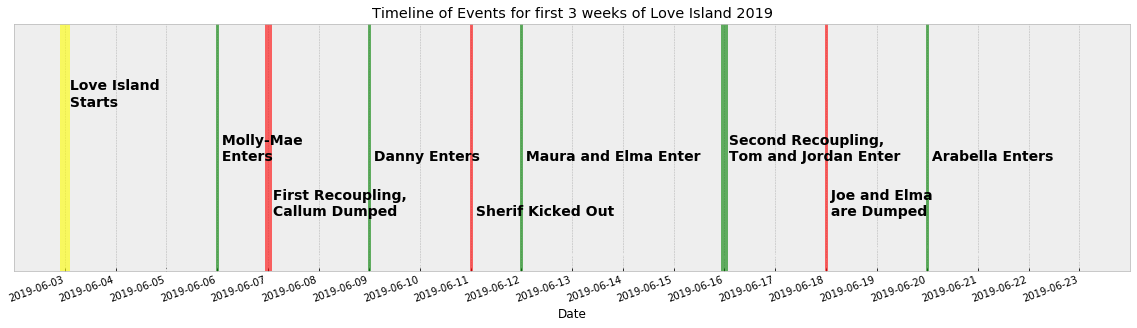

In [36]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)

sns.lineplot(
    x="date",
    y="score",
    color="#EEEEEE",
    data=agg_df[agg_df["islander"] == "anton"],
    ax=ax1,
)
plt.xticks(rotation=20, ha="right")
ax1.set(
    xticks=agg_df.date.unique(),
    yticks=[],
    xlabel="Date",
    ylabel="",
    ylim=(0, 3),
    title="Timeline of Events for first 3 weeks of Love Island 2019",
)

for key, item in EVENTS.items():
    ax1.axvline(item["date"], color=item["color"], linewidth=item["t"], alpha=0.6)
    ax1.text(item["date"], 2 * item["h"] / 3, key, fontsize=14, weight="bold")


### Initial Statistics 
Prior to looking at the sentiment data, let's briefly go over some summary plots so we can see what the data we are dealing with looks like. Plotting the number of tweets per day we find that there is a lot of variance; there is an obvious peak on the first day and there is no consistency with what day of the week had the most tweets as one might expect with a regular show. The day with the 2nd most tweets was the 13th June, this coincides with the day after Maura entered the villa; given her actions in the first few days prompted [486 complaints to Ofcom (the British TV regulator](https://www.cosmopolitan.com/uk/entertainment/a28073036/ofcom-complaints-love-island-maura-joe/) this is not a surprise. The very notable troughs observed every 7 days all fall on Saturdays; the only day of the week Love Island is not on. In the first 3 weeks of Love Island, there were 1.08 million tweets that explicitly referenced the show; an average of over 51,000 a day. 

Total number of tweets in first 3 weeks of Love Island: 1080583
Mean number of tweets per day in first 3 weeks of Love Island: 51456.333333333336


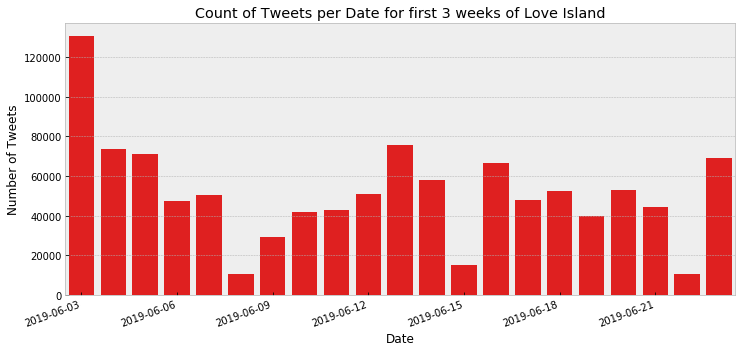

In [37]:
to_plot = sf.get_counts(df, "date")

print("Total number of tweets in first 3 weeks of Love Island:", to_plot["count"].sum())
print(
    "Mean number of tweets per day in first 3 weeks of Love Island:",
    to_plot["count"].mean(),
)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "count", data=to_plot, color="Red", ax=ax1)

sf.format_xticks(to_plot, ax1, 3)
ax1.set(
    xlabel="Date",
    ylabel="Number of Tweets",
    title="Count of Tweets per Date for first 3 weeks of Love Island",
);

Given our interest in the islanders themselves we can take a look at how many tweets reference at least one of the cast members; over the first 3 weeks an average of 55.9% of tweets a day specifically name at least one of the contestants. This summary statistic doesn't paint the full picture however, we see the percentage rising as we progress though the series as twitter users "get to know" the cast more and firm favourites and grow to like / dislike couples more. Of the days the show is on, in the 3rd week we find that well over 60% of tweets contain a mention of one of the islanders, whilst they can't see their twitter at this moment in time (participants have no access to the outside world during their time on the show), when they leave the villa this sort of activity about them personally will be a huge change in their life. The day with the highest percentage of tweets specifically mentioning an islander was 16th June, this was the second "re-coupling" and the first time in the series there was a lot of drama coming to a climax. 

Mean percentage of tweets per day in first 3 weeks of Love Island that reference an islander: 55.937905619736306


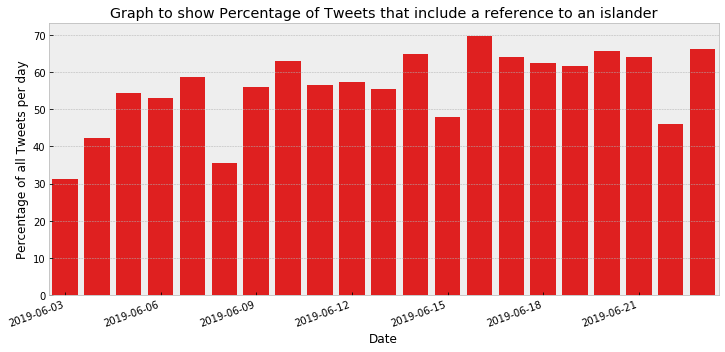

In [38]:
to_plot = sf.get_ref_perc(df)

print(
    "Mean percentage of tweets per day in first 3 weeks of Love Island that reference an islander:",
    to_plot["perc"].mean(),
)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "perc", data=to_plot, color="Red", ax=ax1)

sf.format_xticks(to_plot, ax1, 3)

ax1.set(
    xlabel="Date",
    ylabel="Percentage of all Tweets per day",
    title="Graph to show Percentage of Tweets that include a reference to an islander",
);

### Trending Sentiment per Islander over time 

In order to assess if we can see the on-screen events in the corpus of tweets scraped, we can find the sentiment and aggregate per day all the tweets that mention by name an islander. The only filters we shall use are excluding days where we see less 100 tweets per islander (to reduce noise in the graphs) and including only tweets where the sentiment is not 0 again to reduce noise (and given we want to observe reactions to events, not having a reaction and simply just referencing should be excluded!)

Overlaying the "event bars" from the above plot will help us correlate what is happening on twitter with what happened during the show. Whilst we are focusing on the sentiment score, it is important to consider the number of tweets about each islander; this might not only explain the sentiment score (if it an extreme value for example) but also will give us more insight into what is happening in terms of reaction to events. 

Firstly, concentrating on the plot of the female islanders, we see a number of interesting trends; looking at the pink line of Amy we see how she starts off as one of the most popular islanders in week one but as the series goes on she becomes one of the most unpopular. The opposite is true for Amber, who starts off the series as the least popular female but finishes as one of the most popular; when she came into the villa she was seen as too upfront and rude but as she had more airtime and she began to open up with Micheal the public began to warm to her. Anna follows a similar pattern to Amber however tweets are initially slightly more positive about her, given their friendship it is not surprising that the publics reaction to them follows the same trajectory. Yewande is the female islander who stayed "in favour" for the longest time; she was one of the most popular for the first two weeks yet in the third week she starts to fall out of popularity.

Next moving onto the male islanders, much like Amy, Curtis starts as one of the most popular islanders and as more shows are aired his popularity drops, given that Amy and Curtis were a strong couple from the very first show it would be expected that they had similar trends. Micheal is the one islander (out of both male and female) that maintains popularity right through the whole of the first three weeks, he is also the only islander to have a mean score of over 0.4 on any day. Whilst in part 1 of this investigation we saw that Tommy was one of the most popular islanders to be spoken about prior to the show starting, when the series began he consistently received some of the lowest sentiment scores per day. Anton is the one boy to consistently grow throughout the series; he started as one of the least popular and ended this period as one of the most popular, this is down to his intro video being extremely unpopular however when we saw what he was really like, the public warmed to him, this is evidence for how much power the producers of the show have and how they can really dictate the on-screen image of the contestants. 

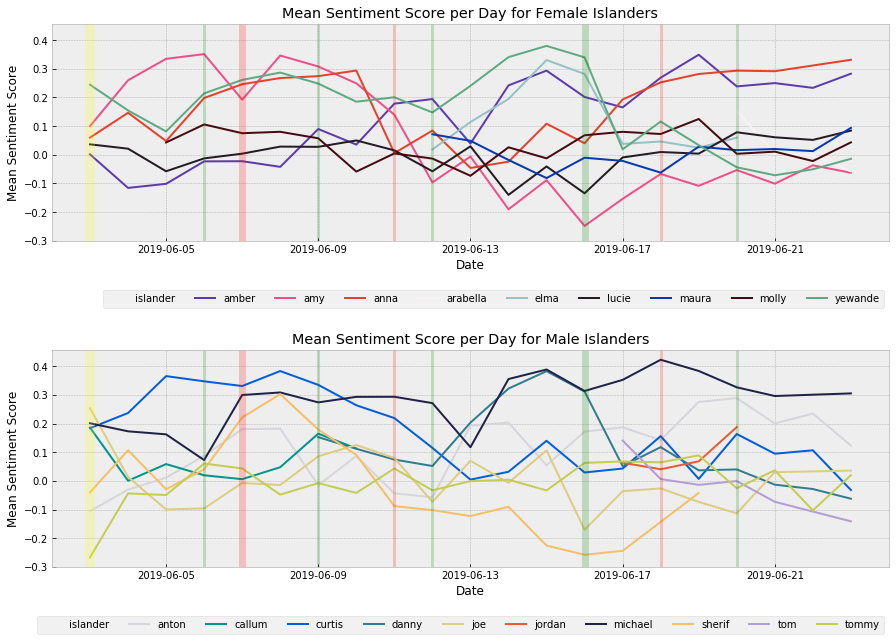

In [39]:
args = {"x": "date", "y": "score", "hue": "islander", "palette": PALETTE}

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(data=agg_df[agg_df["sex"] == "female"], ax=ax1, **args)
sf.add_meta(
    ax1, "Mean Sentiment Score", "Mean Sentiment Score per Day for Female Islanders"
)
sf.add_colours(ax1, EVENTS)

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
sns.lineplot(data=agg_df[agg_df["sex"] == "male"], ax=ax2, **args)
sf.add_meta(
    ax2, "Mean Sentiment Score", "Mean Sentiment Score per Day for Male Islanders"
)
sf.add_colours(ax2, EVENTS)

plt.subplots_adjust(hspace=0.5);

### Number of Tweets per Islander per day
As well as finding the sentiment scores, we should also note the number of tweets about each islander. Once there have been a number of episodes "setting the scene" where the viewers start to find out more about the islanders personalities and friendships/couples start to form, the real drama of the show starts to begin and the fallouts and clashes between islanders get the most reactions online. The first real example of this is the "Tommy-Joe-Lucie love triangle" that we see start to form after a couple of days, on twitter we see these islanders are the most spoken about. When Maura enters the villa there is a large peak, at the same time Molly-Mae and Tommy are also being referenced a lot, here this is the publics reaction to Maura's behaviour and Molly-Mae's reaction to this. 

The largest number of tweets explicitly state an islanders name in the first 3 weeks of the series is Lucie, who was tweeted about over 12,000 times on 15th June. This came as a reaction to the bulling and belittling she received from Amy (who also has a large number of tweets mentioning her on this day); we see that both of these islanders have very low sentiment scores on this episode, given the nature of the topics this might not be a reflection of Lucie and is a caveat to using a machine to read the text. Another example of the potential flaw with the sentiment analyser is we see the average score of Yewande dramatically fall after Arabella entered the villa and her partner Danny begins to stray "get to know" her, here we see the negative sentiment directed at Danny impact Yewande's score due to her being a subject of his actions. 

On the whole, female islanders are tweeted about a lot more than male islanders. It is also true that so far this series, the more tweets that reference an islander, the lower the mean sentiment score; this could be evidence to suggest that the worse the public view your actions to be on screen, the more they will tweet about you. Expanding of this and focusing on the correlation coefficients between mean sentiment score and number of tweets per islander per day, we see that the only positive ones are for Curtis and Tommy, given our knowledge of how these islanders have been viewed by the public (Curtis as the "go-to" islander for good advice and Tommy as a "loveable idiot") this makes sense. At the other end of the spectrum we have Amy and Lucie, here we see very high negative correlations and in the "real world" outside of Love Island, having such a large, negative backlash against you so personally and publicly could be incredibly damaging to an individuals mental health. 

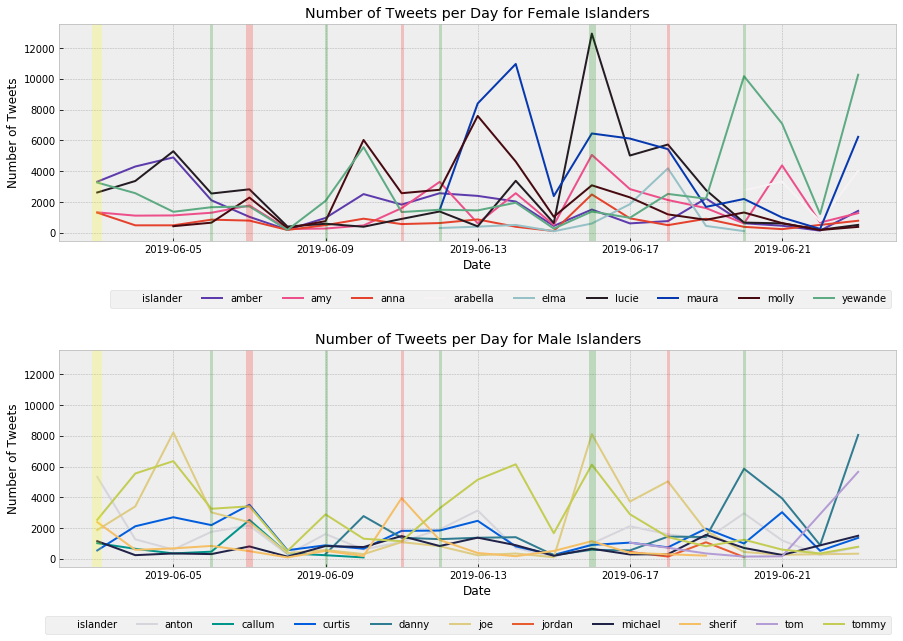

In [40]:
args = {"x": "date", "y": "n_tweets", "hue": "islander", "palette": PALETTE}
    
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
sns.lineplot(data=agg_df[agg_df["sex"]=="female"], ax=ax1, **args)
sf.add_meta(ax1, "Number of Tweets", "Number of Tweets per Day for Female Islanders")
sf.add_colours(ax1, EVENTS)

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
sns.lineplot(data=agg_df[agg_df["sex"]=="male"], ax=ax2, **args)
sf.add_meta(ax2, "Number of Tweets", "Number of Tweets per Day for Male Islanders")
sf.add_colours(ax2, EVENTS)

plt.subplots_adjust(hspace=0.5);

In [41]:
corr_coef = sf.cor_df(agg_df)
corr_coef

,islander,correlation coefficient
0,lucie,-0.661686
1,amy,-0.600760
2,molly,-0.575062
3,yewande,-0.570443
4,tom,-0.549054
5,amber,-0.548784
6,danny,-0.535755
7,joe,-0.524679
8,jordan,-0.353858
9,elma,-0.331624


This investigation set out to determine if we could see reactions on twitter to events on Love Island, given the fact we consistent observed an event happening on the show and a spike in the number of tweets about the relevant islander I believe we have a lot of evidence for this. We also wanted to gain a further understanding into the sentiment behind tweets and how islanders were viewed online, we found that twitter activity was more often than not associated with negative view. It is clear that negative behaviour is reacted to with a lot more activity online than positive behaviours, therefore it is not hard to see how those that pay attention to their public profile get sucked into an incredibly toxic echo chamber.